In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers

In [3]:
df=pd.read_csv('/content/drive/MyDrive/processed_concert_data.csv')
print(df.head(10))


   Avg. Gross USD  Ticket Price Avg. USD  Avg. Event Capacity  Price_Range  \
0        2.552402               0.363094             0.107956    -0.001182   
1        2.886189               0.693551             0.083124    -0.001182   
2       14.796696               1.824159             0.228476    -0.001180   
3        2.952368               0.823170             0.074947    -0.001182   
4       21.967259               2.546260             0.259038    -0.001179   
5        2.192707               0.834180             0.070618    -0.001178   
6        3.203661               0.611181             0.101778    -0.001185   
7       -0.269163              -0.048759            -0.017074    -0.001189   
8        1.926838               0.922126             0.052114    -0.001183   
9        0.453776               0.429297             0.079649    -0.001186   

   Gross_Per_Capacity  Year  Month  Day  Day_of_Year  Is_Weekend  Headliner  \
0            1.249385  2024      9   18          262          

Price_Range unique values: 8023
Top 5 frequent values:
Price_Range
-0.001190    89463
-0.001190    73662
-0.001190    44375
-0.001190    38686
-0.001189    34701
Name: count, dtype: int64

Genre unique values: 595
Top 5 frequent values:
Genre
541    299967
252     34705
292     33066
512     32303
571     24942
Name: count, dtype: int64

Promoter unique values: 14786
Top 5 frequent values:
Promoter
76       211155
10302     55696
3252      19409
6233      16161
11267     15094
Name: count, dtype: int64

City unique values: 3321
Top 5 frequent values:
City
1994    25589
2627    24128
526     21679
2333    21535
302     17121
Name: count, dtype: int64

State unique values: 54
Top 5 frequent values:
State
4     74018
32    58692
44    37226
38    35894
9     32741
Name: count, dtype: int64



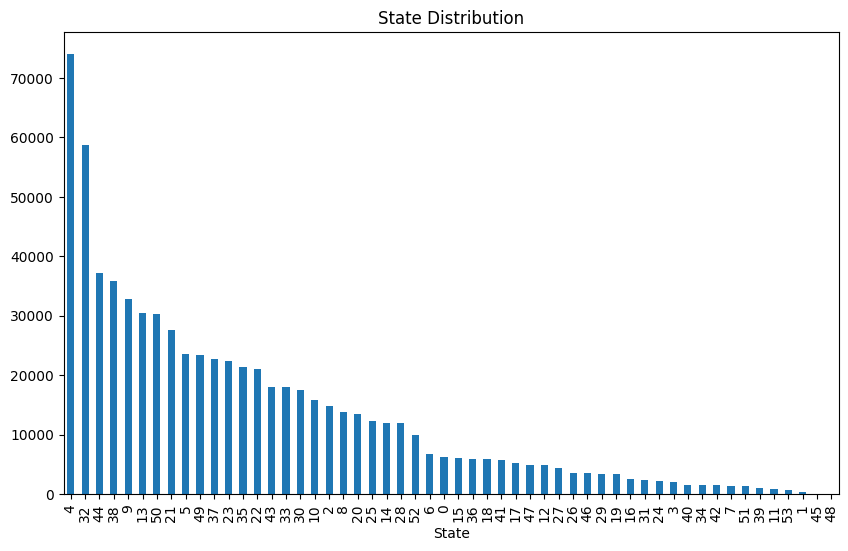

In [ ]:
categorical_cols = ['Price_Range', 'Genre', 'Promoter', 'City', 'State']

for col in categorical_cols:
    print(f"{col} unique values:", df[col].nunique())
    print(f"Top 5 frequent values:\n{df[col].value_counts().head()}\n")

# Visualize State distribution (assuming US state codes)
plt.figure(figsize=(10,6))
df['State'].value_counts().plot(kind='bar')
plt.title('State Distribution')
plt.show()


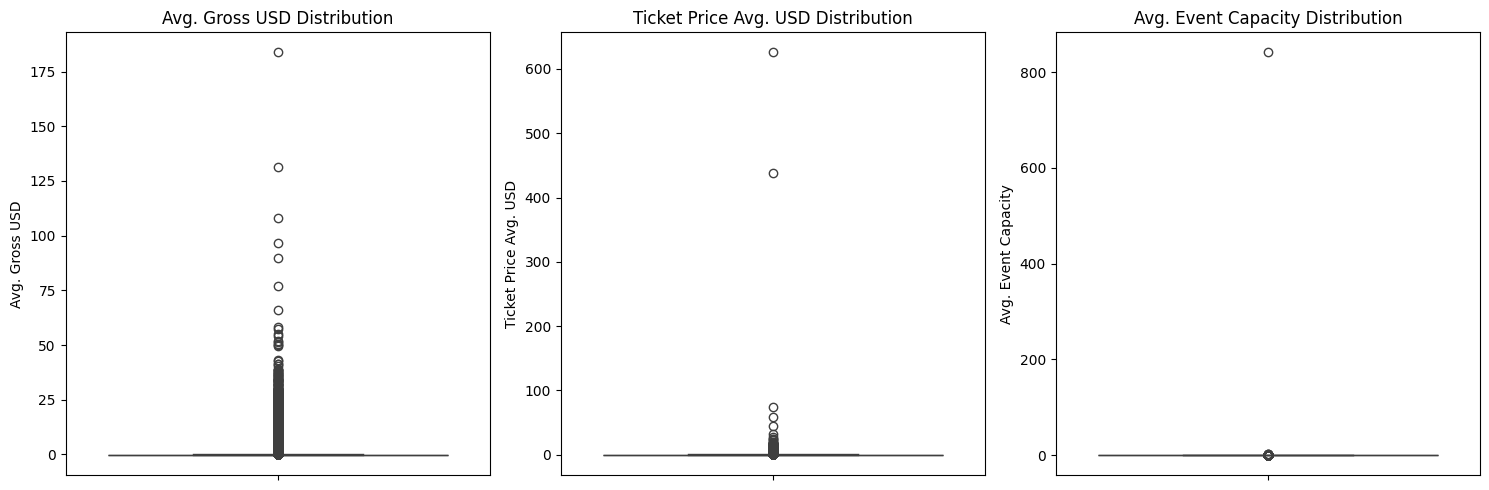

In [ ]:
numeric_cols = ['Avg. Gross USD', 'Ticket Price Avg. USD', 'Avg. Event Capacity']

plt.figure(figsize=(15,5))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1,3,i)
    sns.boxplot(data=df, y=col)
    plt.title(f'{col} Distribution')
plt.tight_layout()

In [ ]:
def data_quality_report(df):
    report = pd.DataFrame({
        'dtype': df.dtypes,
        'missing_values': df.isnull().sum(),
        'missing_%': (df.isnull().sum() / len(df)) * 100,
        'unique_values': df.nunique()
    })
    return report
quality_report = data_quality_report(df)
display(quality_report)

,dtype,missing_values,missing_%,unique_values
Avg. Gross USD,float64,0,0.0,277055
Ticket Price Avg. USD,float64,0,0.0,17637
Avg. Event Capacity,float64,0,0.0,23514
Price_Range,float64,0,0.0,8023
Gross_Per_Capacity,float64,0,0.0,474463
Year,int64,0,0.0,26
Month,int64,0,0.0,12
Day,int64,0,0.0,31
Day_of_Year,int64,0,0.0,366
Is_Weekend,int64,0,0.0,2


In [4]:
target_col = "Avg. Gross USD"
y = df[target_col].values
X = df.drop(columns=[target_col])

In [5]:
numeric_cols = [
    "Ticket Price Avg. USD",
    "Avg. Event Capacity",
    "Price_Range",
    "Gross_Per_Capacity",
    "Year",
    "Month",
    "Day",
    "Day_of_Year",
    "Is_Weekend"
]

cat_cols = [
    "Headliner",
    "Support",
    "Market",
    "Genre",
    "Promoter",
    "Company Type",
    "Venue",
    "City",
    "State"
]

# =======================
# 5
# =======================

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
])

# =======================
# 6
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Processed training data shape:", X_train_processed.shape)
print("Processed test data shape:", X_test_processed.shape)

Processed training data shape: (566102, 18)
Processed test data shape: (141526, 18)


In [6]:
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# =======================
# 8) train model
# =======================
history = model.fit(
    X_train_processed,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3011422.7500 - mae: 834.9728 - val_loss: 1.0226 - val_mae: 0.3558
Epoch 2/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 464.2346 - mae: 1.9619 - val_loss: 1.0211 - val_mae: 0.3495
Epoch 3/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 219.5449 - mae: 0.9995 - val_loss: 1.0211 - val_mae: 0.3497
Epoch 4/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 73.0100 - mae: 0.6552 - val_loss: 1.0211 - val_mae: 0.3499
Epoch 5/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 35.8686 - mae: 0.5303 - val_loss: 1.0211 - val_mae: 0.3501
Epoch 6/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 23.3832 - mae: 0.4503 - val_loss: 1.0211 - val_mae: 0.3502
Epoch 7/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 26.6465 - mae: 0.4241 - val_loss: 1.0211 - val_mae: 0.3501
Epoch 8/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 8.6237 - mae: 0.3904 - val_loss: 1.0211 - val_mae: 0.3499
Epoch 9/50
885/885 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

predictions = model.predict(X_test_processed)
print("Predictions shape:", predictions.shape)
print("Sample predictions:", predictions[:5].flatten())

Test MSE: 0.9099, Test MAE: 0.3497
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Predictions shape: (141526, 1)
Sample predictions: [0.00662785 0.00662785 0.00662785 0.00662785 0.00662785]
